## Movie pipeline


**Main idea**: define UV map for first frame. Then shrink-wrap the first frame onto the mesh of the next frame (i.e. set vertex positions to the closest point on next frame's mesh, with an optional step of affine registration in between). On the shrink-wrapped mesh, we have our UV map, so we can use it for pullbacks. Best to carry out a little (corrective/Taubin) smoothing of shrink-wrap target and wrapped mesh to ensure better results.

**Main problem**: However, shrink-wrap runs into problems when large deformations appear which make remeshing necessary. 

**Possible solutions**:

- Remeshing. In blender, remeshing does _not_ preserve UV info (since you create a new mesh).
    - Pymeshlab: what is the behavior of `meshing_isotropic_explicit_remeshing` ? 

- Instead of deforming mesh of first frame, copy the UV info onto the target mesh. Possible in pymeshlab and blender. Problem: this will create issues at seams - the UV info is interpolated to copy, and this will create bad results where the UV map is discontinouous. Option - only do this from time to time?
    - Pymeshlab: `transfer_attributes_per_vertex`
    
- Subdivision. This creates a new, finer topology, which can accomodate the shape transformations. But the new faces are a superset of the old faces, and hence the UV info is preserved. Applying subdivision _everywhere_ does not help, since this greatly increases the size of the mesh each time. We only want to subdivide where it is necessary.  Note: Catmull-Clark is not great on triangular meshes, made for quads. Multiresolution Modifier in blender? Does not seem to subdivide only where necessary. Adaptive resolution in blender? Loop subdivision algorithm? What about libigl? 
    - Pymeshlab: ` meshing_surface_subdivision_loop`/`meshing_surface_subdivision_ls3_loop`/`meshing_surface_subdivision_butterfly`/`meshing_surface_subdivision_midpoint`. Can select which faces/edges to refine! Very helpful potentially is `meshing_vertex_attribute_seam`.
    - Libigl: `loop`/`loop_subdivision_matrix`. This is _uniform_ remeshing.
    - Trimesh: `trimesh.remesh.subdivide_to_size`. Unfortunately returns a "triangle soup" not an actual mesh.

**Other improvements which may help** 

- What happens if you start with a very deformed mesh and go the other way, i.e. apply your UV map in reverse? In general it is better to go from deformed to less deformed. In particular for growing surfaces, reverse in time is easiest way to go for sure.

- For better quality, create an average shape for making your initial UV map? Like a prototype mesh. Could do so by shrink-wrapping a mesh onto a few targets, and then averaging vertex positions, plus smooth and isotropic remeshing.

**Outlier filtering**

For mesh project.

**Other notes**

- Blender make multi-color surfaces (using texture and material preview) and Semi-Transparent too. Can surely be done without UV map (texture coordinates I think)

**Other options**

The other option, generally speaking, is to UV map from each timepoint mesh separately. Then use a reproducible algorithm of sorts to make sure one has consistent maps. Overall this is the strategy of Noah and Dillon. But this interferes with the idea of a graphical, interactive way of making UV maps! Maybe we can still learn something from the tubular paper.

In [1]:
from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import wrapping as tcwrap

import numpy as np
import igl
from scipy import stats, spatial, linalg, sparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import transform

import warnings
import os
from copy import deepcopy
from tqdm.notebook import tqdm

In [2]:
import pymeshlab
from blender_tissue_cartography import interface_pymeshlab as intmsl

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [3]:
np.set_printoptions(suppress=True)

### Load meshes

This dataset shows the developing _Drosophila_ midgut, courtesy of N. Mitchell. See [Mitchell et al 2022](https://elifesciences.org/articles/77355). The gut undergoes dramatic shape changes (constriction and coiling) as it develops. It is therefore a very challenging test case for a movie pipeline.

We will use meshes of the gut surface already computed by Mitchell et al using a combination of Ilastik + Morphological Snakes + MeshLab, as we show in tutorial XXX:

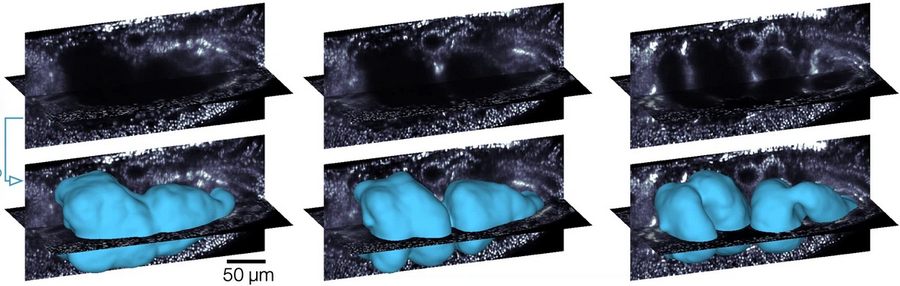

We have a mesh for every timepoint (space 1 min apart in our case).

In [4]:
metadata_dict = {'resolution_in_microns': (1.05, 1.05, 1.05), 'time_resolution_in_minutes': 1}

In [5]:
meshes_dict = {i: tcio.read_other_formats_without_uv(f"movie_example/meshes/mesh_{str(i).zfill(2)}.ply")
               for i in tqdm(range(1, 32))}

  0%|          | 0/31 [00:00<?, ?it/s]

In [6]:
mesh_initial_UV = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")

In the blender file `initial_uv.blend`, we have defined an initial UV mapping for the first mesh. Let's export it!

**Attention** - make sure the axis order is consistent. In this case, we are importing `.ply` meshes which were created in a software which uses a different axis order convention (presumably). After a little experimentation, I found that this is the right axis order for exporting:

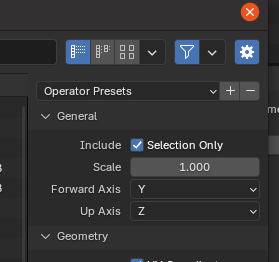

which we can confirm by comparing the overall coordinate ranges.

In [77]:
meshes[0].vertices.max(axis=0), meshes[0].vertices.min(axis=0)

(array([ 526.85229492, 1106.34118652,  582.17089844]),
 array([ 72.30706024, 178.0065918 , 117.39420319]))

In [78]:
mesh_initial_UV.vertices.max(axis=0), mesh_initial_UV.vertices.min(axis=0)

(array([ 525.564026, 1106.09668 ,  583.266541]),
 array([ 71.018806, 177.762115, 118.489838]))

## Load image data and check resolution

In [8]:
original_res_data = "/home/nikolas/Data/Noah gut/deconvolved_16bit/Time_000001_c1_stab.tif"
#image = tcio.adjust_axis_order(tcio.imread(original_res_data))


In [66]:
image = tcio.adjust_axis_order(tcio.imread("movie_example/downsampled_3x/Time_000001_c1_stab-3x.tif"))
image_transposed = image.transpose((0,3,2,1))
# need to swap image axes so they match the x/y/z coordinates of the meshes.
# to do: re-save the meshes in format scaled to microns (not original pixels), and matching image orientation

print("image shape:", image.shape)

image shape: (1, 247, 413, 200)


In [81]:
resolution = 3*[3,]

slice_image, slice_vertices = tcinterp.get_cross_section_vertices_normals(2, 150,
                                image_transposed, mesh_initial_UV, resolution, width=3, get_normals=False)

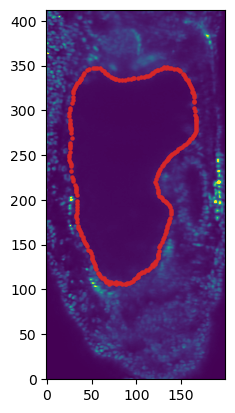

In [83]:
plt.scatter(*slice_vertices.T, s=5, c="tab:red")
plt.imshow(slice_image[0], vmax=10000, origin="lower")

## Shrink-wrapping pipeline

Let's try to serially shrink-wrap our initial mesh onto the subsequent timepoints.

In [28]:
mesh_initial_UV = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [7]:
meshes_wrapped = {1: mesh_initial_UV}

In [8]:
for i in tqdm(range(2, 21)):
    mesh_source = meshes_wrapped[i-1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                    q=0.01, shear=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_centroid_intertia,
                                threshold=1e-4, max_iterations=20, include_scaling=True, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=1, n_iter_smooth_wrapped=1)
    # append to list
    mesh_wrapped.write_obj(f"movie_example/meshes_wrapped/mesh_{str(i).zfill(2)}_wrapped.obj")
    meshes_wrapped[i] = mesh_wrapped

  0%|          | 0/19 [00:00<?, ?it/s]

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 8 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 10 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 5 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
/home/nikolas/Documents/

## Inspect in blender

For the first, say 10 time points, this approach looks decent. After that, we encounter a problem: the surface if the gut deforms very strongly (by forming constrictions), and the shrink-wrapped mesh does not have sufficient resolution to capture the deformation - the triangles in the mesh get extremely stretched. Here is timepoint 20:

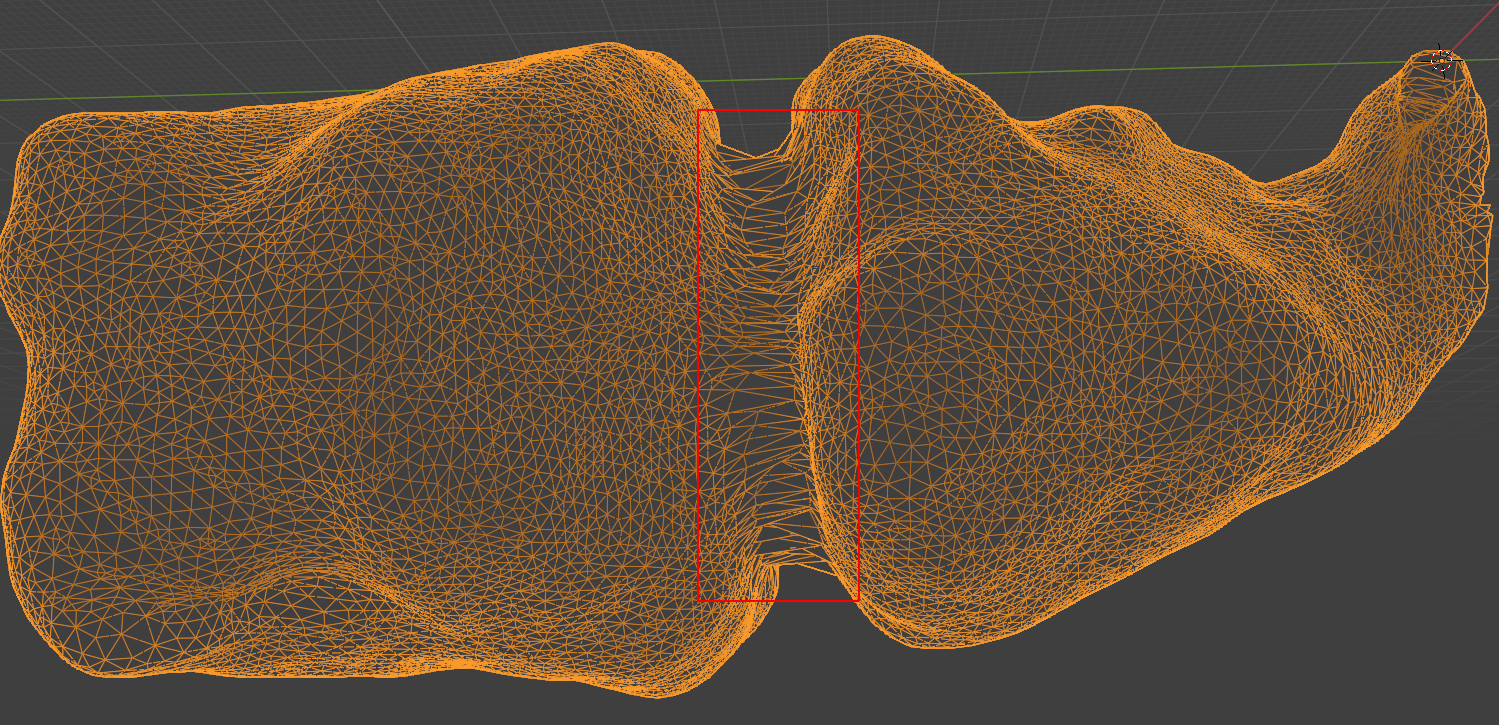

### Idea 1: Operate in reverse time

Let's try a very simple minded thing and define out UV map for timepoint 20 instead, i.e. for the already deformed mesh. And the shrink-wrap in reverse. Let's first try this before defining the UV map.

As we can see, the result is a lot better - instead of getting stretched triangles and a wrapped mesh that can't capture the target deformations anymore, we just get a "compressed" region. This is clearly prefereable.

In [26]:
mesh_final_UV = tcio.ObjMesh.read_obj("movie_example/final_uv.obj") # this is a UV map defined for tpt 20

In [27]:
t_final = 20
meshes_wrapped_reverse = {20: mesh_final_UV}

In [16]:
for i in tqdm(reversed(range(1, t_final))):
    print(i)
    mesh_source = meshes_wrapped_reverse[i+1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                    q=0.01, shear=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_centroid_intertia,
                                threshold=1e-4, max_iterations=20, include_scaling=True, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=1, n_iter_smooth_wrapped=1)
    # append to list
    mesh_wrapped.write_obj(f"movie_example/meshes_wrapped_reverse/mesh_{str(i).zfill(2)}_wrapped_reverse.obj")
    meshes_wrapped_reverse[i] = mesh_wrapped

0it [00:00, ?it/s]

19


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 4 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


18


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 1 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


17
16


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 2 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


15
14
13
12
11
10
9


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 10 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


8


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 6 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


7


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 11 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


6


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 3 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


5
4


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 8 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


3


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 22 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


2


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 13 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


1


### Inspect in blender

The results look decent enough. There are some wrinkles due to the large shape deformation, but the shape matches well (excpet at one of the gut tips).

### Idea 2: Adapt mesh resolution via subdivision/decimation

We can adapt the resolution of our mesh by subdividing stretched triangles and/or decimating compressed triangles. The crux is to do this _without_ destroying the UV map information. However, _subdivision algorithms_ -which, as it says on the tin, refine mesh topology by dividing triangles according to some rule- should be suitable for this, since there is a well-defined map between the topology before and after subdivision. This is _not_ the case with general remeshing algorithms, which effectively create a completely new surface and destroy the UV info.

This is implemented in notebook `05` now. The most effective subdivision algorithms require pymeshlab.

In [38]:
from blender_tissue_cartography import remesh_pymeshlab as tcremesh

In [39]:
mesh_initial_UV = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [40]:
meshes_wrapped_subdivided = {1: mesh_initial_UV}

In [41]:
for i in tqdm(range(2, 21)):
    mesh_source = meshes_wrapped_subdivided[i-1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                    q=0.01, shear=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_centroid_intertia,
                                threshold=1e-4, max_iterations=20, include_scaling=True, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=1, n_iter_smooth_wrapped=1)
    # subdivide
    mesh_wrapped = tcremesh.subdivide_pymeshlab(mesh_wrapped, reglue=True)
    # append to list
    mesh_wrapped.write_obj(f"movie_example/meshes_wrapped_subdivided/mesh_{str(i).zfill(2)}_wrapped.obj")
    meshes_wrapped_subdivided[i] = mesh_wrapped

  0%|          | 0/19 [00:00<?, ?it/s]

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 1 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 13 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:191: RuntimeWarning: Warning: 10 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
/home/nikolas/Documents

The result is already a bit better, but still not completely ideal.

Conversely, for reverse wrapping we want to simplify:

In [75]:
from importlib import reload

In [76]:
reload(tcremesh)

<module 'blender_tissue_cartography.remesh_pymeshlab' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/remesh_pymeshlab.py'>

In [77]:
mesh_final_UV = tcio.ObjMesh.read_obj("movie_example/final_uv.obj") # this is a UV map defined for tpt 20

In [78]:
len(mesh_initial_UV.faces)

40420

In [79]:
t_final = 20
meshes_wrapped_reverse_simplified = {20: mesh_final_UV}

In [81]:
for i in tqdm(reversed(range(1, t_final))):
    print(i)
    mesh_source = meshes_wrapped_reverse_simplified[i+1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                    q=0.01, shear=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_centroid_intertia,
                                threshold=1e-4, max_iterations=20, include_scaling=True, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=1, n_iter_smooth_wrapped=1)
    # simplify
    mesh_wrapped = tcremesh.simplify_pymeshlab(mesh_wrapped, targetfacenum=int(0.5*len(mesh_initial_UV.faces)),
                                               qualitythr=0.9, reglue=False)

    # append to list
    mesh_wrapped.write_obj(f"movie_example/meshes_wrapped_reverse_simplified/mesh_{str(i).zfill(2)}_wrapped_reverse.obj")
    meshes_wrapped_reverse_simplified[i] = mesh_wrapped
    

0it [00:00, ?it/s]

19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


Somehow the simplicifcation does not seem to have the desired result - there are still highly compressed regions in the mesh. Why?

### Idea 3: copy UV map over to target mesh

This does not require adapting topoloy. But it may create problems at the mesh seams! Also unclear how well it will work 

### Option 3: Conformal mapping, via Moebius tranformations.

### Conclusions

- Would be nice to get the remeshing to work better. What about blender Decimate?

- Maybe call it a day. This approach is not suitable for extreme surface deformations.

### Extra software (move this note somewhere else)

- [Boundary first flattening (BFF)](https://geometrycollective.github.io/boundary-first-flattening/) UV mapping tool from Keenan Crane group. Binaries exist for windows & mac. For linux, compile from source. Instructions on website work. Need the following libraries:
    - `sudo apt-get install libsuitesparse-dev xorg-dev libglu1-mesa-dev`
    - Can we use it for uniformization of disks?
    
- [Moebius registration](https://github.com/mkazhdan/MoebiusRegistration) Surface-surface registration tool from Keenan Crane group. Compile from source.
    - Install FFTW: `sudo apt-get install fftw3`
    - Rename `SOFT1.0` directory to `Soft1.0`
    - Type `make` in the directory into which you cloned the github repo
    - Binaries are in `Bin` directory. Running them in the command line prints usage information.
    - Works only with `.ply`. (NEED `.ply` saving method. `meshio` ? `plyfile` ?)
    - You first need to compute a spherical parametrization for your source and target mesh, e.g. `./SphereMap --in mesh_60.ply --out mesh_60_spherical.ply`. Then you can register them: `./Register --correspondence --in mesh_10_spherical.ply mesh_60_spherical.ply  mesh_10_registered_60.ply`
    - Works quite well with default settings. Can registed tpt 10 to tpt 30 of Noah's gut.
    - To do: figure out how to read out the transform from this data!

- [Surface registration via adaptive triangulations](https://github.com/patr-schm/surface-maps-via-adaptive-triangulations). Build according to instructions - straightforward. Doe _NOT_ come with a command line utility allowing for easy use on new meshes. Not usable.


### Remeshing to quad


- To quad: quadriflow. Can't have UVs /normals, need pure obj,. Autoremesh works less well. More poles
- Pymeshlab: remesh isotropic. 
- Libigl: qslim